In [1]:
#!pip install -q torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
#!pip install -q --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install torch-geometric

# link prediction


In [3]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from sklearn.neural_network import MLPClassifier 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from torch_geometric.data import NeighborSampler
from torch.optim import lr_scheduler
import torch.optim as optim
import matplotlib.pyplot as plt
import collections
from concurrent.futures import ThreadPoolExecutor
import numpy as np
from modules.model import Net
import random
from datetime import datetime
from sklearn.metrics import roc_auc_score

import optuna
from modules.negativeSampling import NegativeSampler
from modules.sampling import Sampler, SamplerContextMatrix, SamplerRandomWalk,SamplerFactorization,SamplerAPP

In [10]:
import pickle
import os
import itertools

from torch_geometric.datasets import Flickr
class Main():
    def __init__(self,conv, device, loss_function, mode = 'unsupervised',**kwargs):
        #self.dataset =Flickr(root='/tmp/Flickr',transform=T.NormalizeFeatures())
        self.dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
        
        data = self.dataset[0]
        self.Conv = conv
        self.device = device
        self.x = data.x
        self.y = data.y.squeeze()
        self.data=data.to(device)
        self.dataprocess(data)
        self.loss = loss_function
        self.mode = mode
        self.train_mask = torch.tensor([True]*int(0.8*len(data.x)+1) + [False]*int(0.2*len(data.x)))
        #val_mask = torch.tensor([False]*int(0.6*len(data.x)+1) + [True]*int(0.2*len(data.x)+1)+[False]*int(0.2*len(data.x)))
        self.test_mask = torch.tensor([False]*int(0.8*len(data.x)+1) + [True]*int(0.2*len(data.x)))
        self.flag = self.loss["flag_tosave"]
        
        super(Main, self).__init__()
    def dataprocess(self,data):
        #splitting data to train and test
        train_edge_index = []
        test_edge_index = []
        val_edge_index = []
        d = datetime.now()
        indices_to_delete_for_val  = random.choices(list(range(len(data.edge_index[0]))), k = int(len(data.edge_index[0])*0.2))
        indices_to_delete_for_test  = random.choices( list(set(range(len(data.edge_index[0]))) - set(indices_to_delete_for_val)) , k = int(len(list(set(range(len(data.edge_index[0]))) - set(indices_to_delete_for_val))) *0.625))
      #  print(datetime.now()-d)
        d = datetime.now()
        for i,x in enumerate(list(zip(*data.edge_index.tolist()))):
            if i in indices_to_delete_for_test:
                test_edge_index.append(x)
            elif i in indices_to_delete_for_val: 
                val_edge_index.append(x)
            else: 
                train_edge_index.append(x)
        val_edge_index = torch.tensor(np.array(list(zip(*val_edge_index))))
        test_edge_index = torch.tensor(np.array(list(zip(*test_edge_index))))
        train_edge_index = torch.tensor(np.array(list(zip(*train_edge_index))), dtype = torch.long)
       # print(datetime.now()-d)
        d = datetime.now()
        s = set(itertools.combinations(range(len(data.x)), 2))
       # print(datetime.now()-d)
        d = datetime.now()
        s_of_edges = set()
        for pair in (data.edge_index.t().tolist()):
            s_of_edges.add(tuple(pair))
        s_of_non_edges = s - s_of_edges
        #append negative samples to test set
        non_edges=[]
      #  print(datetime.now()-d)
        d = datetime.now()
        for pair in list(s_of_non_edges):
            non_edges.append(list(pair))
      #  print(datetime.now()-d)
        d = datetime.now()   
        self.non_edges_test=torch.tensor(random.choices(non_edges, k = len(test_edge_index[0]))).t()
        self.non_edges_val=torch.tensor(random.choices(non_edges, k = len(val_edge_index[0]))).t()
        self.y_true_val = [1]*len(val_edge_index[0])
        self.y_true_test = [1]*len(test_edge_index[0])
        self.test_edge_index=torch.cat((test_edge_index,self.non_edges_test),1)
        self.val_edge_index=torch.cat((val_edge_index,self.non_edges_val),1)
        self.y_true_test += [0]*len(self.non_edges_test[0])
        self.y_true_val += [0]*len(self.non_edges_val[0])
        self.data.edge_index = train_edge_index
    
    def sampling(self,Sampler,epoch,nodes):
        if (epoch == 0): 
            if self.flag:  
                if "alpha" in self.loss: 
                    name_of_file = "LP_samples_"+self.loss["Name"]+"_alpha_"+str(self.loss["alpha"])+".pickle"
                else:
                    name_of_file = "LP_samples_"+self.loss["Name"]+".pickle"
                
                if os.path.exists(name_of_file):
                    with open(name_of_file,'rb') as f:
                        self.samples = pickle.load(f)
                else:
                    self.samples = Sampler.sample(nodes) 
                    with open(name_of_file,'wb') as f:
                        self.samples = pickle.dump(self.samples,f)
            else:
                
                self.samples = Sampler.sample(nodes)
        return self.samples
    def train(self, model,data,optimizer,Sampler,train_loader,dropout,epoch):
        model.train()   
        total_loss = 0
        optimizer.zero_grad()
        if model.mode == 'unsupervised':
            if model.conv=='GCN':
                arr=torch.nonzero(self.train_mask == True)
                indices_of_train_data = ([item for sublist in arr for item in sublist])
                out = model.inference(data.to(device),dp=dropout)
                samples = self.sampling(Sampler,epoch, indices_of_train_data)
                loss = model.loss(out[self.train_mask], self.samples)
                total_loss+=loss
            else:
                for batch_size, n_id, adjs in train_loader:
                    if len(train_loader.sizes) == 1:
                        adjs = [adjs]
                    adjs = [adj.to(device) for adj in adjs]
                    out = model.forward(data.x[n_id.to(device)].to(device), adjs)
                    samples = self.sampling(Sampler,epoch,n_id[:batch_size])   
                   
                #print(out.shape, self.samples.shape)
                    loss = model.loss(out, self.samples)#pos_batch.to(device), neg_batch.to(device))
                    total_loss+=loss
            total_loss.backward()
            optimizer.step()      
            return total_loss# /len(train_loader)
        elif model.mode== 'supervised':
            if model.conv=='GCN':
                out = model.inference(data.to(device),dp=dropout)
                loss = model.loss_sup(out[self.train_mask],y[self.train_mask])
                total_loss+=loss
            else:
                for batch_size, n_id, adjs in train_loader:
                    adjs = [adj for adj in adjs]
                    out = model.forward(data.x[n_id].to(device), adjs)
                    loss = model.loss_sup(out,y[n_id[:batch_size]])
                    total_loss+=loss
            total_loss.backward(retain_graph=True)
            optimizer.step()      
            return total_loss #/len(train_loader)  
    

    @torch.no_grad()
    def val_lp(self,model,data,classifier): 
        model.eval()
        out = model.inference(data.to(device))
        y_true = np.array(self.y_true_val)
        if model.mode == 'unsupervised':
            y_pred = []
            for x in list(zip(*self.val_edge_index)):
                y_pred.append(torch.sigmoid(torch.dot(out[x[0]],out[x[1]])))#print(torch.sigmoid(torch.dot(out[x[0]],out[x[1]])))
            return roc_auc_score(y_true,np.array(y_pred)) 
            #return [precision_score(y_true[train_mask.cpu()], best_preds_train, average='macro'), precision_score(y_true[val_mask.cpu()], best_preds_val, average='macro'),precision_score(y_true[test_mask.cpu()], best_preds, average='macro')]
    def test_lp(self,model,data,classifier): 
        model.eval()
        out = model.inference(data.to(device))
        y_true = np.array(self.y_true_test)
        if model.mode == 'unsupervised':
            y_pred = []
            for x in list(zip(*self.test_edge_index)):
                y_pred.append(torch.sigmoid(torch.dot(out[x[0]],out[x[1]])))#print(torch.sigmoid(torch.dot(out[x[0]],out[x[1]])))
            return roc_auc_score(y_true,np.array(y_pred)) 
      
    def run(self,**kwargs):
        hidden_layer = 32
        out_layer = 64
        dropout =  0.4
        size = 1

        learning_rate = 0.007
    
        classifier = "logistic regression"
        train_loader = NeighborSampler(self.data.edge_index, batch_size = int(len(self.data.x)), sizes=[-1]*size)
        Sampler=self.loss["Sampler"]
        LossSampler = Sampler(self.data,device=device,mask=self.train_mask,loss_info=self.loss)
        model = Net(dataset = self.dataset,mode=self.mode,conv=self.Conv,loss_function=self.loss,device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = (size),dropout = dropout)
        model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)
                #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.01, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
        scheduler=lr_scheduler.StepLR(optimizer, step_size=25,gamma=0.1)
        losses=[]
        train_accs=[]
        test_accs=[]
        val_accs=[]
        name_of_plot='conv: '+model.conv+', mode: '+model.mode+', loss from '+self.loss["Name"]

        print(name_of_plot)

        for epoch in range(100):
                    print('epoch',epoch)
                    loss = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch)
                    losses.append(loss)
                    d_test = datetime.now()
                    test_acc = self.test_lp(model,self.data,'logistic regression')
                    test_accs.append(test_acc)
                    log = 'Loss: {:.4f}, Epoch: {:03d}, Test: {:.4f}'
                    #scheduler.step()
                    print(log.format(loss, epoch, test_acc))
        print('Test acc on the last epoch ', test_acc)
        plt.plot(losses)
        plt.title(name_of_plot+' loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
        plt.plot(test_accs)
        plt.title(name_of_plot+' loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
                    #return [precision_score(y_true[train_mask.cpu()], best_preds_train, average='macro'), precision_score(y_true[val_mask.cpu()], best_preds_val, average='macro'),precision_score(y_true[test_mask.cpu()], best_preds, average='macro')]

In [5]:
class MainOptuna(Main):
    def objective(self,trial):
        # Integer parameter
        hidden_layer = trial.suggest_categorical("hidden_layer", [32,64,128,256])
        out_layer = trial.suggest_categorical("out_layer", [32,64,128])
        dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
        size = trial.suggest_categorical("size of network, number of convs", [1,2,3])
        Conv = self.Conv# trial.suggest_categorical("conv", ["SAGE","GCN","GAT"])

        # варьируем параметры
        loss_to_train={}
        for name in self.loss:
            
            if type(self.loss[name]) == list :
                if len(self.loss[name]) == 3:
                    var = trial.suggest_int(name,self.loss[name][0],self.loss[name][1],step=self.loss[name][2])
                    loss_to_train[name] = var
                elif len(self.loss[name]) == 2:
                    var_2 = trial.suggest_float(name,self.loss[name][0],self.loss[name][1])
                    loss_to_train[name] = var_2
                else:
                    var_3 = trial.suggest_categorical(name, self.loss[name])
                    loss_to_train[name] = var_3
            else:
                loss_to_train[name] = self.loss[name]
        Sampler =loss_to_train["Sampler"]
        model = Net(dataset = self.dataset,mode='unsupervised',conv=Conv,loss_function=loss_to_train,device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = size,dropout = dropout)

        train_loader = NeighborSampler(self.data.edge_index, batch_size =int(len(self.data.x)), sizes=[-1]*size)
        
        #train_loader = GraphSAINTRandomWalkSampler(data, batch_size=2176, walk_length=2,num_steps=5, sample_coverage=100,save_dir=dataset.processed_dir,num_workers=4)

        LossSampler = Sampler(self.data,device=self.device,mask=self.train_mask,loss_info=loss_to_train)

        model.to(device)

        learning_rate= trial.suggest_float("lr",5e-4,1e-2)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  

        classifier = "logistic regression" #trial.suggest_categorical("classifier", ["logistic regression", "catboost"])

        if classifier == "catboost":
            n_estimators = trial.suggest_int("n of estimators", 10,40,5)
            learning_rate_catboost = trial.suggest_float("lr_catboost",5e-4,1e-2)
            max_depth = trial.suggest_int("max_depth",1,10,2)
        else:
            n_estimators = -1
            learning_rate_catboost =-1
            max_depth = -1
        #training of the model
        for epoch in range(50):
            loss = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch)
            #print(loss)

        val_acc = self.val_lp(model,self.data,classifier)


        trial.report(val_acc,epoch)

        return val_acc

    
    def run(self,number_of_trials):

        study = optuna.create_study(direction="maximize",study_name=self.loss["Name"]+" loss,"+str(self.Conv)+" conv")
        study.optimize(self.objective,n_trials = number_of_trials)

        print('Best trial:')
        trial = study.best_trial
        print(" Value: ", trial.value)
        print(" Params: ")
        for key, value in trial.params.items():
            print(" {}: {}".format(key,value))
    

In [6]:
 #SAGE = {"Name":"SAGE" , "walk_length":[5,20,5],"walks_per_node":[5,20,5],"num_negative_samples":20,"context size" : [5,20,5],"p":1,"q":1, "loss var": "Random Walks","flag":False,"Sampler" =SamplerRandomWalk }
from modules.sampling import Sampler, SamplerContextMatrix, SamplerRandomWalk,SamplerFactorization,SamplerAPP
DeepWalk = {"Name": "DeepWalk","walk_length":[5,20,5],"walks_per_node":[5,20,5],"num_negative_samples":[1,21,5],"context_size" : [5,20,5],"p":1,"q":1,"loss var": "Random Walks","flag_tosave":False,"Sampler" : SamplerRandomWalk } #Проблемы с памятью после того, как увеличила количество тренировочных данных
Node2Vec = {"Name": "Node2Vec","walk_length":[5,20,5],"walks_per_node":[5,20,5],"num_negative_samples":[1,21,5],"context_size" : [5,20,5],"p": [0.0,0.9] ,"q":[0.0,0.9], "loss var": "Random Walks","flag_tosave":False,"Sampler": SamplerRandomWalk}#то же самое 

LINE = {"Name": "LINE","C": "Adj","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":True,"Sampler" :SamplerContextMatrix} 
HOPE_RPR = {"Name": "HOPE_RPR","C":"RPR","loss var": "Factorization","flag_tosave":True,"alpha": [0,1],"Sampler" :SamplerFactorization} #проверить
HOPE_Katz = {"Name": "HOPE_Katz","C":"Katz","loss var": "Factorization","flag_tosave":True,"betta": [0,1],"Sampler" :SamplerFactorization,} #проверить
HOPE_CN = {"Name": "HOPE_CommonNeighbors","C":"CN","loss var": "Factorization","flag_tosave":True,"Sampler" :SamplerFactorization} 
HOPE_AA = {"Name": "HOPE_AdamicAdar","C":"AA","loss var": "Factorization","flag_tosave":True,"Sampler" :SamplerFactorization} 

LapEigen = {"Name": "LaplacianEigenMaps", "C":"Adj","loss var": "Laplacian EigenMaps","flag_tosave":True,"Sampler" :SamplerFactorization}
GraphFactorization = {"Name": "Graph Factorization","C":"Adj","loss var": "Factorization","flag_tosave":True,"Sampler" :SamplerFactorization} 

VERSE_PPR =  {"Name": "VERSE_PPR","C": "PPR","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":True,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerContextMatrix}
VERSE_SR =  {"Name": "VERSE_SimRank","C": "SR","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":True,"Sampler":SamplerContextMatrix} 
VERSE_Adj =  {"Name": "VERSE_Adj","C": "Adj","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":True,"Sampler" :SamplerContextMatrix} 

APP ={"Name": "APP","C": "PPR","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":False,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerAPP}

Struc2Vec ={} #Implement

In [8]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss = GraphFactorization
MO = MainOptuna('SAGE', device, loss , mode = 'unsupervised')
MO.run(number_of_trials=50)

[I 2021-04-26 19:30:03,485] A new study created in memory with name: Graph Factorization loss,SAGE conv
[I 2021-04-26 19:30:10,772] Trial 0 finished with value: 0.5840489003129946 and parameters: {'hidden_layer': 128, 'out_layer': 32, 'dropout': 0.1, 'size of network, number of convs': 3, 'lr': 0.00672213854826853}. Best is trial 0 with value: 0.5840489003129946.
[I 2021-04-26 19:30:18,063] Trial 1 finished with value: 0.522892655129599 and parameters: {'hidden_layer': 128, 'out_layer': 32, 'dropout': 0.1, 'size of network, number of convs': 2, 'lr': 0.006474405474024392}. Best is trial 0 with value: 0.5840489003129946.
[I 2021-04-26 19:30:25,401] Trial 2 finished with value: 0.5448886089743181 and parameters: {'hidden_layer': 128, 'out_layer': 64, 'dropout': 0.4, 'size of network, number of convs': 3, 'lr': 0.004253665274610616}. Best is trial 0 with value: 0.5840489003129946.
[I 2021-04-26 19:30:32,752] Trial 3 finished with value: 0.8803628091308846 and parameters: {'hidden_layer': 

[I 2021-04-26 19:33:43,178] Trial 29 finished with value: 0.8853359662028982 and parameters: {'hidden_layer': 256, 'out_layer': 64, 'dropout': 0.4, 'size of network, number of convs': 1, 'lr': 0.006919778262092863}. Best is trial 25 with value: 0.9122201250151847.
[I 2021-04-26 19:33:50,434] Trial 30 finished with value: 0.8660934843949625 and parameters: {'hidden_layer': 256, 'out_layer': 64, 'dropout': 0.4, 'size of network, number of convs': 1, 'lr': 0.006746842155866559}. Best is trial 25 with value: 0.9122201250151847.
[I 2021-04-26 19:33:57,692] Trial 31 finished with value: 0.8955031004750952 and parameters: {'hidden_layer': 256, 'out_layer': 64, 'dropout': 0.5, 'size of network, number of convs': 1, 'lr': 0.007147385296914701}. Best is trial 25 with value: 0.9122201250151847.
[I 2021-04-26 19:34:04,945] Trial 32 finished with value: 0.8695705712627784 and parameters: {'hidden_layer': 256, 'out_layer': 64, 'dropout': 0.5, 'size of network, number of convs': 1, 'lr': 0.0061287350

Best trial:
 Value:  0.9178121595516742
 Params: 
 hidden_layer: 256
 out_layer: 64
 dropout: 0.4
 size of network, number of convs: 1
 lr: 0.007195871717666327


conv: SAGE, mode: unsupervised, loss from Graph Factorization
epoch 0
Loss: 3055.4734, Epoch: 000, Test: 0.5995
epoch 1
Loss: 2417.7485, Epoch: 001, Test: 0.5852
epoch 2
Loss: 2859.0552, Epoch: 002, Test: 0.5847
epoch 3
Loss: 2647.4460, Epoch: 003, Test: 0.5873
epoch 4
Loss: 2449.3145, Epoch: 004, Test: 0.5897
epoch 5
Loss: 2405.0535, Epoch: 005, Test: 0.5918
epoch 6
Loss: 2425.8374, Epoch: 006, Test: 0.5988
epoch 7
Loss: 2444.4294, Epoch: 007, Test: 0.6105
epoch 8
Loss: 2427.1533, Epoch: 008, Test: 0.6224
epoch 9
Loss: 2393.3848, Epoch: 009, Test: 0.6293
epoch 10
Loss: 2367.9519, Epoch: 010, Test: 0.6396
epoch 11
Loss: 2356.4602, Epoch: 011, Test: 0.6509
epoch 12
Loss: 2354.7366, Epoch: 012, Test: 0.6512
epoch 13
Loss: 2357.1570, Epoch: 013, Test: 0.6470
epoch 14
Loss: 2357.8979, Epoch: 014, Test: 0.6460
epoch 15
Loss: 2353.3877, Epoch: 015, Test: 0.6478
epoch 16
Loss: 2344.7229, Epoch: 016, Test: 0.6511
epoch 17
Loss: 2335.7261, Epoch: 017, Test: 0.6550
epoch 18
Loss: 2329.0950, Epoc

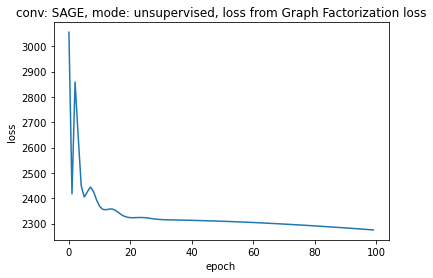

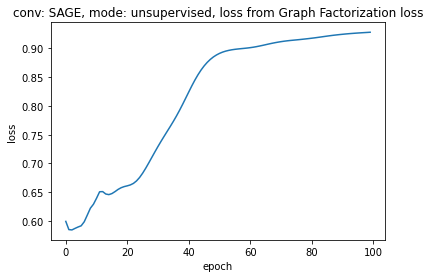

In [11]:
device =  torch.device('cpu')# if torch.cuda.is_available() else 'cpu')
DeepWalk = {"Name": "DeepWalk","walk_length":20,"walks_per_node":10,"num_negative_samples":1,"context_size" : 15,"p":1,"q":1,"loss var": "Random Walks","flag_tosave":False,"Sampler" : SamplerRandomWalk } #Проблемы с памятью после того, как увеличила количество тренировочных данных

loss = GraphFactorization
MO = Main('SAGE', device, loss , mode = 'unsupervised')
MO.run()
